## Dolly 3B Model - by Databricks
---
1. Model Name: Dolly-v2-3b
2. Model Parameters: 3 Billion
3. Training: Instruction-tuned Model
4. Link: https://huggingface.co/databricks/dolly-v2-3b
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
csv_file_path = '/content/drive/MyDrive/mini proj/balanced_tweets.csv'
df = pd.read_csv(csv_file_path)

In [ ]:
df.head()

,airline_sentiment,clean_tweet
0,neutral,start daily b flights columbus oh oakland aug ...
1,positive,beautiful fleet perfect evening fly
2,negative,beg differ things booked wrong still fixed get...
3,neutral,good point
4,neutral,hear new thing planes fly fi check flight im g...


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['airline_sentiment'] = le.fit_transform(df['airline_sentiment'])

print(df.head())

   airline_sentiment                                        clean_tweet
0                  1  start daily b flights columbus oh oakland aug ...
1                  2                beautiful fleet perfect evening fly
2                  0  beg differ things booked wrong still fixed get...
3                  1                                         good point
4                  1  hear new thing planes fly fi check flight im g...


In [ ]:
# install dependencies
!pip install transformers
!pip install sentencepiece
!pip install accelerate

In [ ]:
import torch                        # allows Tensor computation with strong GPU acceleration
from transformers import pipeline   # fast way to use pre-trained models for inference
import os

In [ ]:
# load model
dolly_pipeline = pipeline(model="databricks/dolly-v2-3b",
                            torch_dtype=torch.bfloat16,
                            trust_remote_code=True,
                            device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Modify the get_completion_dolly function for sentiment analysis
def get_sentiment_dolly(input_text):
    system = """
    You are an expert in sentiment analysis.
    Please classify the sentiment of the following sentence into three categories:
    0 - Negative, 1 - Neutral, 2 - Positive.
    Respond with just the label (0, 1, or 2) based on the sentiment of the text.
    """
    prompt = f"#### System: {system}\n#### User: \n{input_text}\n\n#### Response from Dolly-v2-3b:"
    dolly_response = dolly_pipeline(prompt, max_new_tokens=2)  # Expecting a small output (just the label)
    return dolly_response[0]["generated_text"].strip()  # Clean output

In [ ]:
from tqdm import tqdm

In [ ]:
# Add a sentiment prediction column to your dataset
sentiments = []
for text in tqdm(df['clean_tweet'], desc="Predicting Sentiment"):
    sentiment = get_sentiment_dolly(text)
    sentiments.append(sentiment)

Predicting Sentiment: 100%|██████████| 7089/7089 [40:18<00:00,  2.93it/s]


In [ ]:
# Add the predictions to your dataframe
df['predicted_sentiment'] = sentiments

In [ ]:
import re
from sklearn.metrics import accuracy_score

# Function to extract the numeric sentiment label (e.g., '2 Positive' -> 2)
def extract_sentiment_label(sentiment_str):
    match = re.match(r'(\d+)\s', sentiment_str)  # Looks for a number followed by whitespace
    if match:
        return int(match.group(1))
    else:
        return -1  # If there is an error in the format, return an invalid value

# Apply the function to convert predicted sentiment to integer labels
df['predicted_sentiment'] = df['predicted_sentiment'].apply(extract_sentiment_label)

# Check if there are any invalid values (e.g., -1) and handle them if necessary
if df['predicted_sentiment'].isnull().any():
    print("Warning: There are some invalid sentiment labels in the predictions!")

# Ensure that 'airline_sentiment' is also in integer format
df['airline_sentiment'] = df['airline_sentiment'].astype(int)

# Calculate accuracy
accuracy = accuracy_score(df['airline_sentiment'], df['predicted_sentiment'])

# Print the accuracy
print(f"Accuracy of sentiment predictions: {accuracy * 100:.2f}%")


Accuracy of sentiment predictions: 85.00%


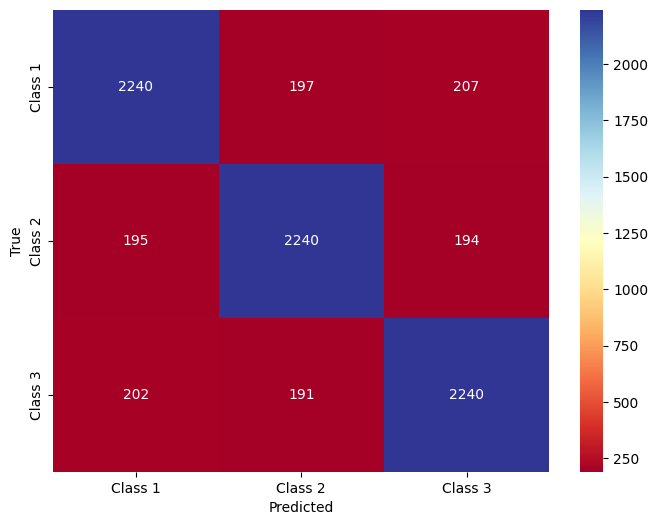

In [ ]:
# Plotting confusion matrix as a heatmap
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="RdYlBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()